# Imports

In [1]:
import numpy as np
import data_preprocessing as dp
import plotting as p

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, MaxPool2D, Conv2D, Conv2DTranspose, \
   Concatenate, Dropout, LeakyReLU, Dense, Activation, Resizing, MaxPooling2D, UpSampling2D

2025-06-18 16:35:17.724131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data preprocessing

## Switzerland

#### Constants

In [2]:
# Switzerland
SWISS_FIRST_LOCATION_RUN = False

swiss_shape_path = "data/Switzerland/switzerland_rect.shx"

swiss_s2_rasters = ["data/Switzerland/S2_switzerland_T32TMT_20240619.tif"]
swiss_s2_merged_path = "data/Switzerland/S2_switzerland_T32TMT_20240619.tif"
swiss_s2_path = 'data/Switzerland/S2_merged_20240619_reproj.tif'

swiss_s1_2024_no_process_path = "data/Switzerland/20240103_20240701.geo.unw.tif"
swiss_s1_2024_path = 'data/Switzerland/20240103_20240701_reproj.geo.unw.tif'
swiss_s1_2023_no_process_path = "data/Switzerland/20230808_20230820.geo.unw.tif"
swiss_s1_2023_path = 'data/Switzerland/20230808_20230820_reproj.geo.unw.tif'

swiss_capella_no_process_path = "data/Switzerland/CAPELLA_C10_SS_GEO_HH_20240515031350_20240515031406.tif"
swiss_capella_path = "data/Switzerland/Capella_20240515_20240515_reproj.tif"

#### Set up

In [3]:
swiss_aoi = dp.get_aoi_geometry(swiss_shape_path, SWISS_FIRST_LOCATION_RUN, 'data/Switzerland/')
swiss_aoi = swiss_aoi.set_crs("EPSG:4326", allow_override=True)

if SWISS_FIRST_LOCATION_RUN:
    dp.get_sentinel2(swiss_aoi, swiss_s2_path, swiss_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=swiss_s2_merged_path, list_files=swiss_s2_rasters
                      )
    dp.get_interferogram(swiss_aoi, swiss_s1_2023_path, ((0, 0), (0, 1), (0, 1)), 
                         swiss_s1_2023_no_process_path
                         )
    dp.get_interferogram(swiss_aoi, swiss_s1_2024_path, ((0, 0), (0, 0), (0, 0)), 
                         swiss_s1_2024_no_process_path
                         )
    dp.get_capella(swiss_aoi, swiss_capella_path, ((0, 0), (0, 1)), swiss_capella_no_process_path)
    dp.get_ref_data(swiss_aoi, 'data/Switzerland/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Switzerland/50N_000E.tif'
                    )

#### Optical - Sentinel 2

In [4]:
swiss_s2_data, swiss_s2_profile = dp.get_sentinel2(aoi=swiss_aoi, file_path=swiss_s2_path, 
                                                   padding=((0, 0), (0, 1), (0, 0)), plot=False
                                                   )

#### SAR - Sentinel 1 interferogram

In [5]:
swiss_s1_2023_data, swiss_s1_2023_profile = dp.get_interferogram(aoi=swiss_aoi, file_path=swiss_s1_2023_path, 
                                                                 padding=((0, 0), (0, 1), (0, 1)), plot=False
                                                                 )
swiss_s1_2024_data, swiss_s1_2024_profile = dp.get_interferogram(aoi=swiss_aoi, file_path=swiss_s1_2024_path,
                                                                 padding=((0, 0), (0, 0), (0, 0)), plot=False
                                                                 )

#### SAR - Capella

In [6]:
swiss_capella_data, swiss_capella_profile = dp.get_capella(aoi=swiss_aoi, file_path=swiss_capella_path, 
                                                           padding=((0, 0), (0, 1)), plot=False
                                                           )

#### Stacking

In [7]:
swiss_combined = np.concatenate((swiss_s2_data, swiss_s1_2023_data, swiss_s1_2024_data), axis=0)

#### Reference data

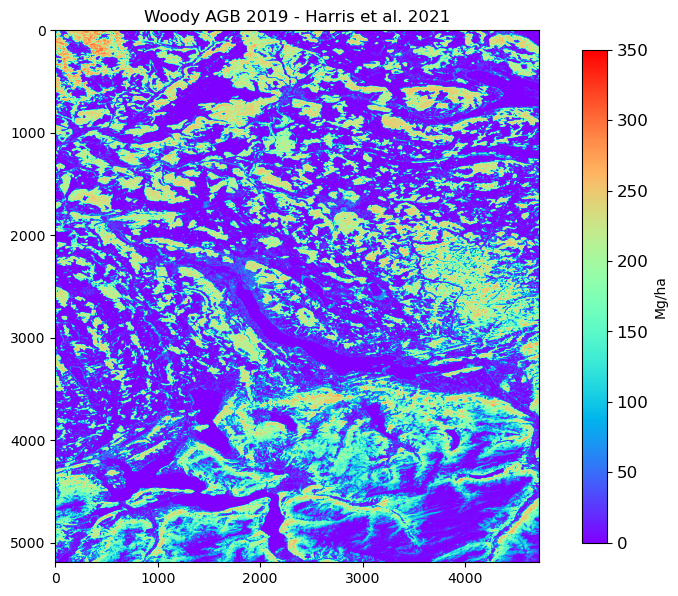

In [8]:
swiss_ref_data, swiss_ref_profile = dp.get_ref_data(aoi=swiss_aoi, 
                                                    file_path='data/Switzerland/ref_data_abg_woody.tif', 
                                                    padding=((1, 0), (0, 0))
                                                    )

#### Formatting for models

In [9]:
n_bands, height, width = swiss_combined.shape
n_pixels = height * width

# Make bands last and decrease dimensions
swiss_X_2d = np.transpose(swiss_combined, (1, 2, 0)).reshape(n_pixels, n_bands)       # (w*h, 14)
swiss_y_1d = swiss_ref_data.reshape(n_pixels)             # (w*h, )

# Fill in holes in the dataset
imputer = SimpleImputer(strategy='mean')
swiss_X_2d = imputer.fit_transform(swiss_X_2d)

# Split into test and train data
swiss_X_train, swiss_X_test, swiss_y_train, swiss_y_test = train_test_split(
                                                            swiss_X_2d, 
                                                            swiss_y_1d,
                                                            test_size=0.3, 
                                                            random_state=42
                                                        )

## Italy

#### Constants

In [10]:
italy_shape_path = "data/Italy/italy_rect.shx"

italy_s2_rasters = ['data/Italy/S2_italy_T32TNR_20240316.tif', 'data/Italy/S2_italy_T32TNS_20240311.tif', 'data/Italy/S2_italy_T32TPR_20240412.tif', 'data/Italy/S2_italy_T32TPS_20240412.tif']
italy_s2_merged_path = "data/Italy/S2_merged_20240311-20240412.tif"
italy_s2_path = 'data/Italy/S2_merged_20240311-20240412_repoj.tif'

italy_s1_no_process_path = "data/Italy/20240203_20240227.geo.unw.tif"
italy_s1_path = 'data/Italy/S1_inter_20240203_20240227_reproj.geo.unw.tif'

italy_capella_no_process_path = "data/Italy/Capella-Italy(20240219).tif"
italy_capella_path = "data/Italy/Capella-Italy(20240219)_reproj.tif"

ITALY_FIRST_LOCATION_RUN = False

#### Set up 

In [11]:
italy_aoi = dp.get_aoi_geometry(italy_shape_path, ITALY_FIRST_LOCATION_RUN, 'data/Italy/italy_rect.shx')
italy_aoi = italy_aoi.set_crs("EPSG:4326", allow_override=True)

if ITALY_FIRST_LOCATION_RUN:
    dp.get_sentinel2(italy_aoi, italy_s2_path, italy_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=italy_s2_merged_path, list_files=italy_s2_rasters
                      )
    dp.get_interferogram(italy_aoi, italy_s1_path, ((0, 0), (0, 1), (0, 1)), 
                         italy_s1_no_process_path
                         )
    dp.get_capella(italy_aoi, italy_capella_path, ((0, 0), (0, 1)), italy_capella_no_process_path)
    dp.get_ref_data(swiss_aoi, 'data/Italy/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Italy/50N_010E.tif'
                    )

#### Optical - Sentinel 2

In [13]:
italy_s2_data, italy_s2_profile = dp.get_sentinel2(aoi=italy_aoi, file_path=italy_s2_path,
                                                   padding=((0, 0), (0, 0), (0, 1)), plot=False
                                                   )

#### SAR - Sentinel 1

In [14]:
italy_s1_data, italy_s1_profile = dp.get_interferogram(aoi=italy_aoi, file_path=italy_s1_path, 
                                                       padding=((0, 0), (0, 1), (0, 1)), plot=False
                                                       )

#### Stacking

In [15]:
italy_combined = np.concatenate((italy_s2_data, italy_s1_data), axis=0)

#### Reference data

In [17]:
italy_ref_data, ref_data_profile = dp.get_ref_data(aoi=italy_aoi, file_path='data/Italy/ref_data_abg_woody.tif',
                                                   padding=((0, 0), (1, 1)), plot=False
                                                   )

#### Format for modeling

In [18]:
n_bands, height, width = italy_combined.shape
n_pixels = height * width

# Reshape to make the bands last
italy_X_2d = np.transpose(italy_combined, (1, 2, 0)).reshape(n_pixels, n_bands)       # (w*h, 14)
italy_y_1d = italy_ref_data.reshape(n_pixels)             # (w*h, )


# For no image processers
# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
italy_X_2d = imputer.fit_transform(italy_X_2d)

# Split into test and train 
italy_X_train, italy_X_test, italy_y_train, italy_y_test = train_test_split(
    italy_X_2d, italy_y_1d, test_size=0.3, random_state=42
)

## Germany

#### Constants

In [19]:
de_shape_path = "data/Germany/germany_rect.shx"

de_s2_rasters = ["data/Germany/S2_germany_T33UUU_20220312.tif", "data/Germany/S2_germany_T33UUV_20220312.tif", 
                         "data/Germany/S2_germany_T33UVU_20220314.tif", "data/Germany/S2_germany_T33UVV_20220314.tif"]
de_s2_merged_path = "data/Germany/S2_merged_20220312-14.tif"
de_s2_path = 'data/Germany/S2_merged_20220312-14_reproj.tif'

de_terrasar_no_process_path = "data/Germany/dims_op_oc_dfd2_695017442_1/TSX-1.SAR.L1B/TSX1_SAR__MGD_SE___SM_S_SRA_20220523T052620_20220523T052628/IMAGEDATA/IMAGE_HH_SRA_strip_011.tif"
de_terrasar_path = "data/Germany/TerraSAR_20220523_reproj.tif"

de_iceye_no_process_path = "data/Germany/ICEYE_X11_GRD_SC_2631255_20230902T005432.tif_Cal_Spk_TC.tif"
de_iceye_path = 'data/Germany/ICEYE_X11_GRD_SC_20230902_reproj.tif'

DE_FIRST_LOCATION_RUN = False

#### Set up

In [ ]:
de_aoi = dp.get_aoi_geometry(de_shape_path, False)
de_aoi = de_aoi.set_crs("EPSG:4326", allow_override=True)

if DE_FIRST_LOCATION_RUN:
    dp.get_sentinel2(de_aoi, de_s2_path, de_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=de_s2_merged_path, list_files=de_s2_rasters
                      )
    dp.get_terrasar(de_aoi, de_terrasar_no_process_path, ((0, 0), (0, 1), (0, 1)), 
                        de_terrasar_path
                    )
    dp.get_iceye(de_aoi, de_iceye_path, ((0, 0), (0, 1)), de_iceye_no_process_path)
    dp.get_ref_data(de_aoi, 'data/Germany/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Germany/60N_010E.tif'
                    )

#### Optical - Sentinel 2

In [21]:
de_s2_data, de_s2_profile = dp.get_sentinel2(aoi=de_aoi, file_path=de_s2_path, 
                                             padding=((0, 0), (0, 0), (0, 1)), plot=False
                                             )

#### SAR - TerraSAR

In [22]:
de_terrasar_data, de_terrasar_profile = dp.get_terrasar(aoi=de_aoi, 
                                                        file_path=de_terrasar_path, 
                                                        padding=((0, 0), (0, 1)), plot=False
                                                        )

#### SAR - Iceye

In [23]:
de_iceye_data, de_iceye_profile = dp.get_iceye(aoi=de_aoi, file_path=de_iceye_path, 
                                               padding=((0, 0), (0, 2)), plot=False
                                               )

#### Stacking

In [24]:
de_combined = np.concatenate((de_s2_data, de_terrasar_data, de_iceye_data), axis=0)

#### Reference data

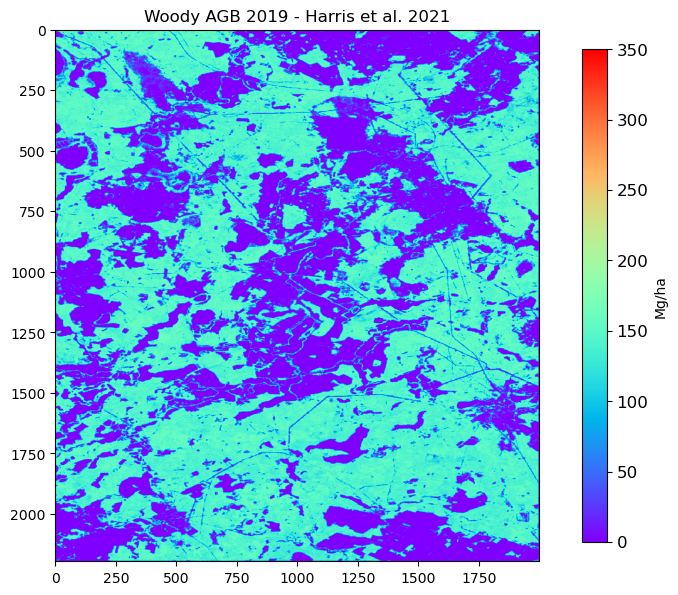

In [27]:
de_ref_data, de_ref_profile = dp.get_ref_data(de_aoi,'data/Germany/ref_data_abg_woody.tif', ((0, 0), (0, 1)))


#### Formatting for models

In [28]:
n_bands, height, width = de_combined.shape
n_pixels = height * width

# Reshape to make the bands last
de_X_2d = np.transpose(de_combined, (1, 2, 0)).reshape(n_pixels, n_bands)       # (w*h, 14)
de_y_1d = de_ref_data.reshape(n_pixels)             # (w*h, )


# For no image processers
# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
de_X_2d = imputer.fit_transform(de_X_2d)

# Split into test and train 
de_X_train, de_X_test, de_y_train, de_y_test = train_test_split(
    de_X_2d, de_y_1d, test_size=0.3, random_state=42
)

## Panama

#### Constants

In [29]:
# Panama
PA_FIRST_LOCATION_RUN = False

pa_shape_path = "data/Panama/panama_rect.shx"

pa_s2_rasters = ["data/Panama/S2_panama_T17PPK_20211210.tif", "data/Panama/S2_panama_T17PPL_20221210.tif"]
pa_s2_merged_path = "data/Panama/S2_merged_20211210.tif"
pa_s2_path = 'data/Panama/S2_merged_20211210_reproj.tif'

pa_s1_no_process_path = "data/Panama/S1_inter_20220128_20220209.geo.unw.tif"
pa_s1_path = 'data/Panama/S1_inter_20220128_20220209_reproj.geo.unw.tif'

pa_capella_path = "data/Panama/CAPELLA_C09_SM_GEO_HH_20240806035526_20240806035544.tif"

pa_iceye_no_process_path = "data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC.tif"
pa_iceye_path = 'data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC_reproj.tif'

#### Set up

In [ ]:
pa_aoi = dp.get_aoi_geometry(pa_shape_path, PA_FIRST_LOCATION_RUN)
pa_aoi = pa_aoi.set_crs("EPSG:4326", allow_override=True)

if PA_FIRST_LOCATION_RUN:
    dp.get_sentinel2(pa_aoi, pa_s2_path, pa_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=pa_s2_merged_path, list_files=pa_s2_rasters
                      )
    dp.get_interferogram(pa_aoi, pa_s1_path, ((0, 0), (0, 1), (0, 1)), 
                        pa_s1_no_process_path
                    )
    dp.get_iceye(pa_aoi, pa_iceye_path, ((0, 0), (0, 1)), pa_iceye_no_process_path)
    dp.get_ref_data(pa_aoi, 'data/Panama/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Panama/60N_010E.tif'
                    )

#### Optical - Sentinel 2

In [31]:
pa_s2_data, pa_s2_profile = dp.get_sentinel2(aoi=pa_aoi, file_path=pa_s2_path, 
                                             padding=((0, 0), (0, 0), (0, 1)), plot=False
                                            )

#### SAR - Sentinel 1 interferogram

In [32]:
pa_s1_data, pa_s1_profile = dp.get_interferogram(aoi=pa_aoi, file_path=pa_s1_path, 
                                                 padding=((0, 0), (0, 1), (0, 0)), plot=False
                                                )

#### SAR - Iceye

In [33]:
pa_iceye_data, pa_iceye_profile = dp.get_iceye(aoi=pa_aoi, file_path=pa_iceye_path, 
                                               padding=((0, 0), (0, 1)), plot=False
                                              )

#### Stacking

In [34]:
pa_combined = np.concatenate((pa_s2_data, pa_s1_data, pa_iceye_data), axis=0)

#### Reference data

In [36]:
pa_ref_data, pa_ref_profile = dp.get_ref_data(aoi=pa_aoi, file_path='data/Panama/ref_data_abg_woody.tif', 
                                              padding=((0,0), (0,0)), plot=False)

#### Format for modeling

In [37]:
n_bands, height, width = pa_combined.shape
n_pixels = height * width

# Reshape to make the bands last
pa_X_2d = np.transpose(pa_combined, (1, 2, 0)).reshape(n_pixels, n_bands)       # (w*h, 14)
pa_y_1d = pa_ref_data.reshape(n_pixels)             # (w*h, )


# For no image processers
# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
pa_X_2d = imputer.fit_transform(pa_X_2d)

# Split into test and train 
pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(
    pa_X_2d, pa_y_1d, test_size=0.3, random_state=42
)

# Experiments

### Basic - control run

##### Germany

In [38]:
# Fit linear regression model
de_mlr_model = LinearRegression()
de_mlr_model.fit(de_X_2d, de_y_1d)

# Predict
de_mlr_pred = de_mlr_model.predict(de_X_2d)

# Compute metrics
de_mlr_mse = mean_squared_error(de_y_1d, de_mlr_pred)
de_mlr_r2 = r2_score(de_y_1d, de_mlr_pred)

print(f"Mean Squared Error: {de_mlr_mse}")
print(f"R² Score: {de_mlr_r2}")

# Reshape prediction to original 2D format for visualization or further use
de_mlr_pred_image = de_mlr_pred.reshape(height, width)
p.plot_raster(de_mlr_pred_image, 'MLR Prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

Mean Squared Error: 2924.1558785931034
R² Score: 0.37267454880019935


ValueError: cannot reshape array of size 4387608 into shape (4360,3964)

In [39]:
# Build random forest model
de_rf_model = RandomForestRegressor(
    n_estimators=50,       # fewer trees → faster
    max_depth=15,          # cap tree height → fewer splits
    max_samples=0.25,      # each tree sees only 25% of pixels
    max_features=5,        # at each split, consider 5 of the 8 PCA features
    n_jobs=-1,             # use all CPU cores
    random_state=42,
    verbose=1
)

# Fit on training
de_rf_model.fit(de_X_train, de_y_train)

# Predict the values
de_rf_pred = de_rf_model.predict(de_X_2d)

# Compute metrics
de_rf_mse = mean_squared_error(de_y_1d, de_rf_pred)
de_rf_r2 = r2_score(de_y_1d, de_rf_pred)

print(f"Mean Squared Error: {de_rf_mse}")
print(f"R² Score: {de_rf_r2}")

# Reshape back into the raster
de_rf_pred_image = de_rf_pred.reshape(height, width)
p.plot_raster(de_rf_pred_image, 'RF Prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   19.0s finished


Mean Squared Error: 903.2185962553735
R² Score: 0.8062305715040861


ValueError: cannot reshape array of size 4387608 into shape (4360,3964)

In [ ]:
# Train XGBoost (handles NaNs internally)
de_gbt_model = xgb.XGBRegressor(tree_method='hist')  # 'hist' is faster for large data
de_gbt_model.fit(de_X_train, de_y_train)

# Predict and evaluate
de_gbt_pred = de_gbt_model.predict(de_X_2d)

# Compute metrics
de_gbt_mse = mean_squared_error(de_y_1d, de_gbt_pred)
de_gbt_r2 = r2_score(de_y_1d, de_gbt_pred)

print(f"Mean Squared Error: {de_gbt_mse}")
print(f"R² Score: {de_gbt_r2}")

# Reshape back into the raster
de_gbt_pred_image = de_gbt_pred.reshape(height, width)
p.plot_raster(de_gbt_pred_image, 'GBT Prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

##### Switzerland

In [ ]:
# Fit linear regression model
swiss_mlr_model = LinearRegression()
swiss_mlr_model.fit(swiss_X_2d, swiss_y_1d)

# Predict
swiss_mlr_pred = swiss_mlr_model.predict(swiss_X_2d)

# Compute metrics
swiss_mlr_mse = mean_squared_error(swiss_y_1d, swiss_mlr_pred)
swiss_mlr_r2 = r2_score(swiss_y_1d, swiss_mlr_pred)
print(f"Mean Squared Error: {swiss_mlr_mse}")
print(f"R² Score: {swiss_mlr_r2}")

# Reshape prediction to original 2D format for visualization or further use
swiss_mlr_pred_image = swiss_mlr_pred.reshape(height, width)
p.plot_raster(swiss_mlr_pred_image, 'MLR prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

In [ ]:
# Build random forest model
swiss_rf_model = RandomForestRegressor(
                    n_estimators=50,
                    max_depth=15,
                    max_samples=0.25,
                    max_features=5,
                    n_jobs=-1,
                    random_state=42,
                    verbose=1
                )

# Fit on training
swiss_rf_model.fit(swiss_X_train, swiss_y_train)

# Predict the values
swiss_rf_pred = swiss_rf_model.predict(swiss_X_2d)

# Compute metrics
swiss_rf_mse = mean_squared_error(swiss_y_1d, swiss_rf_pred)
swiss_rf_r2 = r2_score(swiss_y_1d, swiss_rf_pred)
print(f"Mean Squared Error: {swiss_rf_mse}")
print(f"R² Score: {swiss_rf_r2}")

# Reshape back into the raster
swiss_rf_pred_image = swiss_rf_pred.reshape(height, width)

p.plot_raster(swiss_rf_pred_image, 'RF prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

In [ ]:
# Train XGBoost (handles NaNs internally)
swiss_gbt_model = xgb.XGBRegressor(tree_method='hist')  # 'hist' is faster for large data
swiss_gbt_model.fit(swiss_X_train, swiss_y_train)

# Predict and evaluate
swiss_gbt_pred = swiss_gbt_model.predict(swiss_X_2d)

# Compute metrics
swiss_gbt_mse = mean_squared_error(swiss_y_1d, swiss_gbt_pred)
swiss_gbt_r2 = r2_score(swiss_y_1d, swiss_gbt_pred)
print(f"Mean Squared Error: {swiss_gbt_mse}")
print(f"R² Score: {swiss_gbt_r2}")

# Reshape back into the raster
swiss_gbt_pred_image = swiss_gbt_pred.reshape(height, width)
p.plot_raster(swiss_gbt_pred_image, 'GBT prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

##### Italy

In [ ]:
# Fit linear regression model
italy_mlr_model = LinearRegression()
italy_mlr_model.fit(italy_X_2d, italy_y_1d)

# Predict
italy_mlr_pred = italy_mlr_model.predict(italy_X_2d)

# Compute metrics
italy_mlr_mse = mean_squared_error(italy_y_1d, italy_mlr_pred)
italy_mlr_r2 = r2_score(italy_y_1d, italy_mlr_pred)

print(f"Mean Squared Error: {italy_mlr_mse}")
print(f"R² Score: {italy_mlr_r2}")

# Reshape prediction to original 2D format for visualization or further use
italy_mlr_pred_image = italy_mlr_pred.reshape(height, width)

p.plot_raster(italy_mlr_pred_image, 'MLR Prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

In [ ]:
# Build random forest model
italy_rf_model = RandomForestRegressor(
    n_estimators=50,       # fewer trees → faster
    max_depth=15,          # cap tree height → fewer splits
    max_samples=0.25,      # each tree sees only 25% of pixels
    max_features=5,        # at each split, consider 5 of the 8 PCA features
    n_jobs=-1,             # use all CPU cores
    random_state=42,
    verbose=1
)

# Fit on training
italy_rf_model.fit(italy_X_train, italy_y_train)

# Predict the values
italy_rf_pred = italy_rf_model.predict(italy_X_2d)

# Compute metrics
italy_rf_mse = mean_squared_error(italy_y_1d, italy_rf_pred)
italy_rf_r2 = r2_score(italy_y_1d, italy_rf_pred)

print(f"Mean Squared Error: {italy_rf_mse}")
print(f"R² Score: {italy_rf_r2}")

# Reshape back into the raster
italy_rf_pred_image = italy_rf_pred.reshape(height, width)

p.plot_raster(italy_rf_pred_image, 'RF Prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

In [ ]:
# Train XGBoost (handles NaNs internally)
italy_gbt_model = xgb.XGBRegressor(tree_method='hist')  # 'hist' is faster for large data
italy_gbt_model.fit(italy_X_train, italy_y_train)

# Predict and evaluate
italy_gbt_pred = italy_gbt_model.predict(italy_X_2d)

# Compute metrics
italy_gbt_mse = mean_squared_error(italy_y_1d, italy_gbt_pred)
italy_gbt_r2 = r2_score(italy_y_1d, italy_gbt_pred)

print(f"Mean Squared Error: {italy_gbt_mse}")
print(f"R² Score: {italy_gbt_r2}")

# Reshape back into the raster
italy_gbt_pred_image = italy_mlr_pred.reshape(height, width)
p.plot_raster(italy_gbt_pred_image, 'GBT Prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

#### Panama

In [ ]:
# Fit linear regression model
pa_mlr_model = LinearRegression()
pa_mlr_model.fit(pa_X_2d, pa_y_1d)

# Predict
pa_mlr_pred = pa_mlr_model.predict(pa_X_2d)

# Compute metrics
pa_mlr_mse = mean_squared_error(pa_y_1d, pa_mlr_pred)
pa_mlr_r2 = r2_score(pa_y_1d, pa_mlr_pred)

print(f"Mean Squared Error: {pa_mlr_mse}")
print(f"R² Score: {pa_mlr_r2}")

# Reshape prediction to original 2D format for visualization or further use
pa_mlr_pred_image = pa_mlr_pred.reshape(height, width)

p.plot_raster(pa_mlr_pred_image, 'MLR Prediction', 'rainbow', normalized=False, cbar_label='Mg/ha')

In [ ]:
# Build random forest model
pa_rf_model = RandomForestRegressor(
    n_estimators=50,       # fewer trees → faster
    max_depth=15,          # cap tree height → fewer splits
    max_samples=0.25,      # each tree sees only 25% of pixels
    max_features=5,        # at each split, consider 5 of the 8 PCA features
    n_jobs=-1,             # use all CPU cores
    random_state=42,
    verbose=1
)

# Fit on training
pa_rf_model.fit(pa_X_train, pa_y_train)

# Predict the values
pa_rf_pred = pa_rf_model.predict(pa_X_2d)

# Compute metrics
pa_rf_mse = mean_squared_error(pa_y_1d, pa_rf_pred)
pa_rf_r2 = r2_score(pa_y_1d, pa_rf_pred)

print(f"Mean Squared Error: {pa_rf_mse}")
print(f"R² Score: {pa_rf_r2}")

# Reshape back into the raster
pa_rf_pred_image = pa_rf_pred.reshape(height, width)

p.plot_raster(pa_rf_pred_image, 'RF predictions', 'rainbow', normalized=False, cbar_label='Mg/ha')

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
# Train XGBoost (handles NaNs internally)
pa_gbt_model = xgb.XGBRegressor(tree_method='hist')  # 'hist' is faster for large data
pa_gbt_model.fit(pa_X_train, pa_y_train)

# Predict and evaluate
pa_gbt_pred = pa_gbt_model.predict(pa_X_2d)

# Compute metrics
pa_gbt_mse = mean_squared_error(pa_y_1d, pa_gbt_pred)
pa_gbt_r2 = r2_score(pa_y_1d, pa_gbt_pred)

print(f"Mean Squared Error: {pa_gbt_mse}")
print(f"R² Score: {pa_gbt_r2}")

pa_gbt_pred_image = pa_gbt_pred.reshape(height, width)
p.plot_raster(pa_gbt_pred_image, 'GBT Predictions', 'rainbow', normalized=False, cbar_label='Mg/ha')